In [1]:
# Brute-Force (BF) Matcher + K-Nearest Neighbors (KNN) 匹配，并结合了 Lowe’s Ratio Test 来筛选最佳匹配点

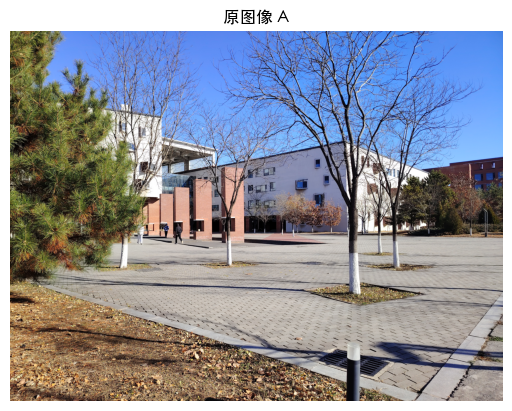

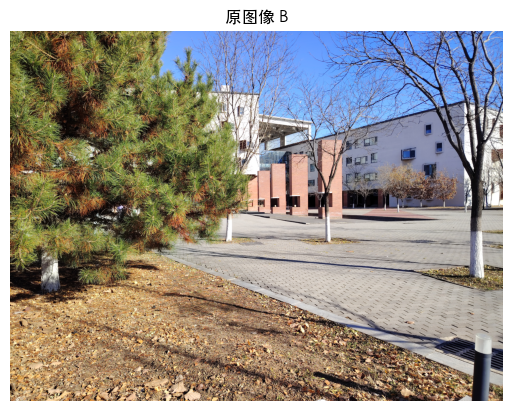

图像 A 尺寸: (3000, 4000, 3)
图像 B 尺寸: (3000, 4000, 3)
[detectAndDescribe] 完成，耗时: 1.8627 秒
[detectAndDescribe] 完成，耗时: 1.3403 秒
图像 A 特征点数量: 130588
图像 B 特征点数量: 163995


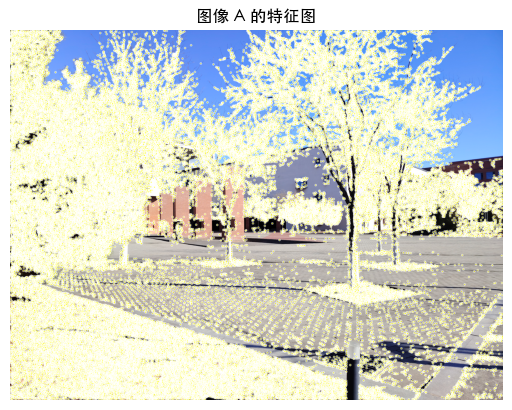

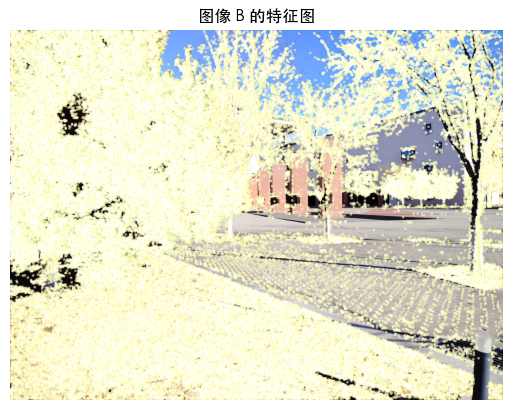

[match_keypoints] 完成，找到初始匹配对: 130588，通过比率测试后: 6782，平均匹配距离: 105.82，耗时: 71.7347 秒
A 和 B 之间的有效匹配点数量（通过比率测试）: 6782
平均匹配距离: 105.82


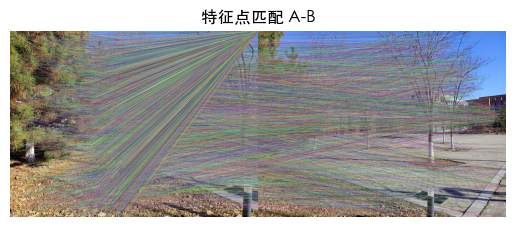

[stitch_images] 内点数量: 3838/6782，内点比例: 0.57
[stitch_images] 拼接完成，耗时: 0.0855 秒


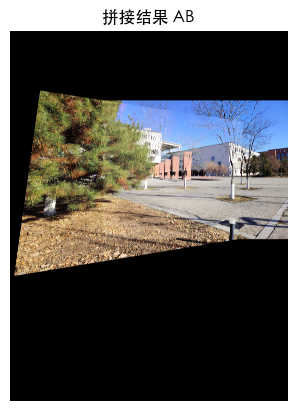

拼接结果已保存至: ./output_KNN/stitched_3_4.jpg


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time  # === 新增或修改 ===

# 设置全局字体（这里以 SimHei 为例）
plt.rcParams['font.sans-serif'] = ['STHeiti']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# ============================
# 配置参数
# ============================
imageA_path = "../datasets/new_data/3.jpg"  # 图像 A 的路径
imageB_path = "../datasets/new_data/4.jpg"  # 图像 B 的路径

distance_ratio = 0.5         # KNN 匹配的距离比率（用于 Lowe 的比率测试）
ransac_threshold = 5         # RANSAC 阈值
min_matches_required = 4     # 计算单应性矩阵所需的最小匹配点数量

gaussian_kernel_size = (7, 7)  # 高斯模糊的内核大小

def show_image(image, title="Image"):
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detectAndDescribe(image):
    """
    图像预处理和特征提取函数，包括高斯模糊滤波和灰度化，然后进行特征点检测和描述。
    """
    # === 新增或修改 ===
    # 记录开始时间（用于统计检测+描述时间）
    t0 = time.time()

    # 转换为灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 使用高斯模糊去噪
    denoised = cv2.GaussianBlur(gray, gaussian_kernel_size, 0)

    # 特征检测和描述
    descriptor = cv2.SIFT_create()
    (kps, des) = descriptor.detectAndCompute(denoised, None)
    kps_float = np.float32([kp.pt for kp in kps])

    # === 新增或修改 ===
    # 统计完成时间并打印日志
    t1 = time.time()
    print(f"[detectAndDescribe] 完成，耗时: {t1 - t0:.4f} 秒")
    
    return (kps, kps_float, des)

def match_keypoints(desA, desB):
    """
    使用 KNN 算法进行特征匹配，并应用 Lowe 的比率测试筛选优秀匹配点
    """
    # === 新增或修改 ===
    # 记录开始时间（用于统计匹配时间）
    t0 = time.time()

    matcher = cv2.BFMatcher()
    rawMatches = matcher.knnMatch(desA, desB, 2)

    good_matches = []
    matches = []
    
    # 用于统计距离的列表
    distances = []
    
    for m, n in rawMatches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append([m])
            matches.append((m.queryIdx, m.trainIdx))
            distances.append(m.distance)
    
    # 计算平均匹配距离
    avg_distance = np.mean(distances) if len(distances) > 0 else -1

    # === 新增或修改 ===
    # 输出一些信息
    t1 = time.time()
    print(f"[match_keypoints] 完成，找到初始匹配对: {len(rawMatches)}，"
          f"通过比率测试后: {len(good_matches)}，"
          f"平均匹配距离: {avg_distance:.2f}，"
          f"耗时: {t1 - t0:.4f} 秒")
    
    return good_matches, matches, avg_distance

def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    if not good_matches or not isinstance(good_matches[0], list):
        print("Error: good_matches 格式不正确，应为包含 DMatch 对象的列表列表。")
        return None
    
    vis = cv2.drawMatchesKnn(imageB, kpsB, imageA, kpsA,
                             good_matches, None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return vis

def stitch_images(center_image, align_image, center_kps_float, align_kps_float, matches):
    """
    利用匹配点计算单应性矩阵并进行图像拼接
    """
    if len(matches) > min_matches_required:
        pts_center = np.float32([center_kps_float[i] for (i, _) in matches])
        pts_align = np.float32([align_kps_float[j] for (_, j) in matches])

        # === 新增或修改 ===
        # 记录开始时间（统计拼接时间）
        t0 = time.time()

        # 使用 RANSAC 计算单应性矩阵
        H, status = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)

        if status is None:
            print("[stitch_images] RANSAC 计算失败，无法获得单应矩阵。")
            return None
        else:
            inlier_count = np.sum(status)  # 内点数量
            total_count = len(matches)
            inlier_ratio = inlier_count / float(total_count)

            print(f"[stitch_images] 内点数量: {inlier_count}/{total_count}，"
                  f"内点比例: {inlier_ratio:.2f}")
            
            # 拼接图像
            height_center, width_center = center_image.shape[:2]
            canvas_size = (height_center * 2, width_center * 2)
            translation_dist = (canvas_size[1] // 4, canvas_size[0] // 4)
            H_translation = np.array([[1, 0, translation_dist[0]],
                                      [0, 1, translation_dist[1]],
                                      [0, 0, 1]], dtype=np.float32)

            result = cv2.warpPerspective(center_image, H_translation, canvas_size)
            H_combined = H_translation @ H
            warped_align = cv2.warpPerspective(align_image, H_combined, canvas_size)
            result = np.maximum(result, warped_align)

            # === 新增或修改 ===
            # 记录结束时间并输出耗时
            t1 = time.time()
            print(f"[stitch_images] 拼接完成，耗时: {t1 - t0:.4f} 秒")

            return result
    else:
        print(f"未找到足够的匹配点（需要至少 {min_matches_required} 个）")
        return None

def show_keypoints(image, keypoints, title="Keypoints"):
    image_with_keypoints = image.copy()
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 8, (255, 255, 255), 2)  # 外圈白色
        cv2.circle(image_with_keypoints, (x, y), 4, (0, 255, 255), -1)   # 内圈亮黄色
    show_image(image_with_keypoints, title)


# ============================
# 主流程
# ============================
if __name__ == "__main__":
    imageA = cv2.imread(imageA_path)
    imageB = cv2.imread(imageB_path)

    if imageA is None or imageB is None:
        print("Error: Could not load one or both images.")
    else:
        # 显示原图
        show_image(imageA, '原图像 A')
        show_image(imageB, '原图像 B')

        # === 新增或修改 ===
        # 输出图像尺寸信息
        print(f"图像 A 尺寸: {imageA.shape}")
        print(f"图像 B 尺寸: {imageB.shape}")

        # 提取并显示特征点
        kpsA, kps_floatA, desA = detectAndDescribe(imageA)
        kpsB, kps_floatB, desB = detectAndDescribe(imageB)

        # === 新增或修改 ===
        # 输出特征点数量
        print(f"图像 A 特征点数量: {len(kpsA)}")
        print(f"图像 B 特征点数量: {len(kpsB)}")

        # 显示特征点
        show_keypoints(imageA, kpsA, '图像 A 的特征图')
        show_keypoints(imageB, kpsB, '图像 B 的特征图')

        # 特征匹配
        good_matches_AB, matches_AB, avg_distance_AB = match_keypoints(desA, desB)
        print(f"A 和 B 之间的有效匹配点数量（通过比率测试）: {len(good_matches_AB)}")
        if avg_distance_AB > 0:
            print(f"平均匹配距离: {avg_distance_AB:.2f}")

        # 显示匹配结果
        vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
        if vis_AB is not None:
            show_image(vis_AB, '特征点匹配 A-B')

        # 图像拼接
        stitchedAB = stitch_images(imageA, imageB, kps_floatA, kps_floatB, matches_AB)
        if stitchedAB is not None:
            show_image(stitchedAB, '拼接结果 AB')

            # 保存拼接结果
            baseA = os.path.basename(imageA_path)[-7:-4]
            baseB = os.path.basename(imageB_path)[-7:-4]
            output_filename = f"./output_KNN/stitched_{baseA}_{baseB}.jpg"
            os.makedirs('./output_KNN', exist_ok=True)
            cv2.imwrite(output_filename, stitchedAB)
            print(f"拼接结果已保存至: {output_filename}")
        else:
            print("由于匹配点不足，拼接失败。")